# g_recsys_gnn_v1 — LightGCN Movie Recommender
이 노트북은 `README.md` 요구사항을 LightGCN 기반 파이프라인으로 구현합니다.
- 참고 전략: `docs/claude_v2_gnn.md`, `docs/claude_v2_dl.md`, `docs/gpt_v2.md`
- 목표: 데이터 분석 → 전처리 → LightGCN 학습/평가 → O/X 추천 출력 → 배운 점 정리


## 진행 순서
1. 데이터 로딩 및 통계 재확인 (README 요구사항 0번)
2. ID 매핑 · 사용자 단위 split · negative sampling 도구 제작
3. LightGCN 아키텍처 정의 (docs/claude_v2_gnn.md 추천 설정)
4. BPR 학습 루프 + Recall/NDCG/coverage 평가
5. 임계값 기반 O/X 추론 함수 (README 출력 포맷 충족)
6. 실험 노트 & 회고 (README 4번)


In [1]:

import os
from pathlib import Path
import json
import random
import math
from collections import defaultdict
from typing import Dict, List

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

plt.style.use('ggplot')
SEED = 2024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [2]:

DATA_PATH = Path('data/train.csv')
OUTPUT_DIR = Path('artifacts')
OUTPUT_DIR.mkdir(exist_ok=True)

RATING_POS_THRESHOLD = 4.0  # docs/gpt_v2.md 권장: 3.5 vs 4.0 실험
VAL_RATIO = 0.10
TEST_RATIO = 0.10
NEGATIVE_SAMPLE_RATIO = 4

BATCH_SIZE = 2048
EMBED_DIM = 64
NUM_LAYERS = 3
DROPOUT = 0.10
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 50

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')


Using device: cpu


In [3]:

    ratings_df = pd.read_csv(DATA_PATH)
    ratings_df['label'] = (ratings_df['rating'] >= RATING_POS_THRESHOLD).astype(np.int64)

    num_users_raw = ratings_df['user'].nunique()
    num_items_raw = ratings_df['item'].nunique()
    num_interactions = len(ratings_df)
    density = num_interactions / (num_users_raw * num_items_raw)

    print('--- Dataset Snapshot ---')
    print(ratings_df.head())
    print(f'Users: {num_users_raw:,}, Items: {num_items_raw:,}, Interactions: {num_interactions:,}')
    print(f'Sparsity: {density:.4%} (≈ {100*(1-density):.2f}% empty)')

    user_deg = ratings_df.groupby('user')['item'].count()
    item_deg = ratings_df.groupby('item')['user'].count()
    print('User interactions stats:')
    print(user_deg.describe(percentiles=[0.25, 0.5, 0.75, 0.9]))
    print('Item interactions stats:')
    print(item_deg.describe(percentiles=[0.25, 0.5, 0.75, 0.9]))


--- Dataset Snapshot ---
   user  item  rating  label
0     1    16     4.0      1
1     1    24     1.5      0
2     1    32     4.0      1
3     1    47     4.0      1
4     1    50     4.0      1
Users: 668, Items: 10,321, Interactions: 105,139
Sparsity: 1.5250% (≈ 98.48% empty)
User interactions stats:
count     668.000000
mean      157.393713
std       319.320351
min        20.000000
25%        35.000000
50%        70.000000
75%       153.000000
90%       334.200000
max      5672.000000
Name: item, dtype: float64
Item interactions stats:
count    10321.000000
mean        10.186900
std         22.787637
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
90%         25.000000
max        324.000000
Name: user, dtype: float64


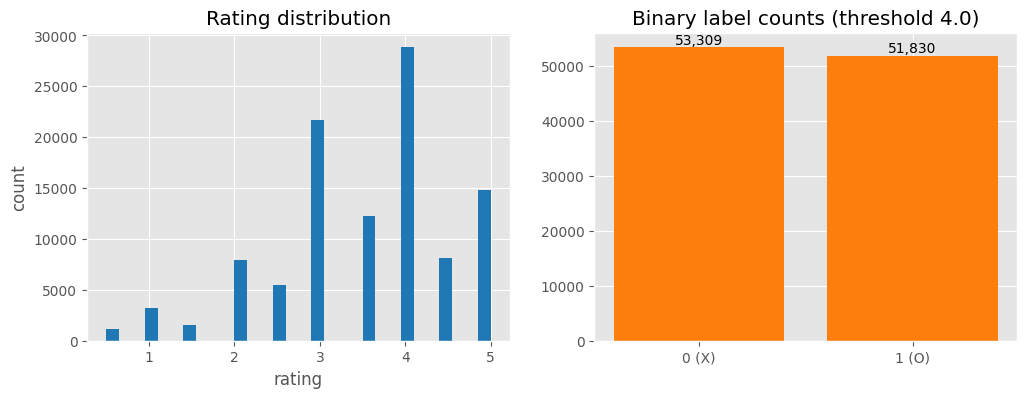

In [4]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ratings_df['rating'].hist(bins=30, ax=ax[0], color='#1f77b4')
ax[0].set_title('Rating distribution')
ax[0].set_xlabel('rating')
ax[0].set_ylabel('count')

label_counts = ratings_df['label'].value_counts().sort_index()
ax[1].bar(['0 (X)', '1 (O)'], label_counts.values, color='#ff7f0e')
ax[1].set_title(f'Binary label counts (threshold {RATING_POS_THRESHOLD:.1f})')
for i, v in enumerate(label_counts.values):
    ax[1].text(i, v, f'{v:,}', ha='center', va='bottom')
plt.show()


In [5]:

def build_id_mappings(df: pd.DataFrame):
    user_ids = sorted(df['user'].unique())
    item_ids = sorted(df['item'].unique())
    user2idx = {u: idx for idx, u in enumerate(user_ids)}
    idx2user = {idx: u for u, idx in user2idx.items()}
    item2idx = {i: idx for idx, i in enumerate(item_ids)}
    idx2item = {idx: i for i, idx in item2idx.items()}
    return user2idx, idx2user, item2idx, idx2item

def apply_mappings(df: pd.DataFrame, user2idx: Dict[int, int], item2idx: Dict[int, int]):
    mapped = df.copy()
    mapped['user_idx'] = mapped['user'].map(user2idx)
    mapped['item_idx'] = mapped['item'].map(item2idx)
    return mapped

def stratified_split(df: pd.DataFrame, val_ratio: float, test_ratio: float, seed: int = 42):
    rng = np.random.default_rng(seed)
    train_rows, val_rows, test_rows = [], [], []
    for _, user_df in df.groupby('user_idx'):
        shuffled = user_df.sample(frac=1.0, random_state=int(rng.integers(0, 1e9))).reset_index(drop=True)
        total = len(shuffled)
        if total <= 2:
            train_rows.append(shuffled.iloc[:1])
            if total == 2:
                val_rows.append(shuffled.iloc[1:2])
            continue
        val_count = max(1, int(total * val_ratio))
        test_count = max(1, int(total * test_ratio))
        remaining = total - val_count - test_count
        if remaining <= 0:
            remaining = max(1, total - 2)
            val_count = 1
            test_count = 1 if total - remaining - val_count >= 1 else 0
        train_rows.append(shuffled.iloc[:remaining])
        val_rows.append(shuffled.iloc[remaining:remaining + val_count])
        if test_count > 0:
            test_rows.append(shuffled.iloc[remaining + val_count:remaining + val_count + test_count])
    train_df = pd.concat(train_rows).reset_index(drop=True)
    val_df = pd.concat(val_rows).reset_index(drop=True) if val_rows else pd.DataFrame(columns=df.columns)
    test_df = pd.concat(test_rows).reset_index(drop=True) if test_rows else pd.DataFrame(columns=df.columns)
    return train_df, val_df, test_df


In [6]:

user2idx, idx2user, item2idx, idx2item = build_id_mappings(ratings_df)
mapped_df = apply_mappings(ratings_df, user2idx, item2idx)

train_full, val_full, test_full = stratified_split(mapped_df, VAL_RATIO, TEST_RATIO, seed=SEED)
print('Split sizes (all labels):', len(train_full), len(val_full), len(test_full))

train_pos = train_full[train_full['label'] == 1].reset_index(drop=True)
val_pos = val_full[val_full['label'] == 1].reset_index(drop=True)
test_pos = test_full[test_full['label'] == 1].reset_index(drop=True)
print('Positive-only split sizes:', len(train_pos), len(val_pos), len(test_pos))

num_users = len(user2idx)
num_items = len(item2idx)

def build_user_pos_dict(df: pd.DataFrame):
    mapping = defaultdict(set)
    for row in df.itertuples():
        mapping[row.user_idx].add(row.item_idx)
    return mapping

train_user_pos = build_user_pos_dict(train_pos)
val_user_pos = build_user_pos_dict(val_pos)
test_user_pos = build_user_pos_dict(test_pos)

popularity_counts = ratings_df.groupby('item')['rating'].count()
max_pop = popularity_counts.max()
popularity_scores = {item2idx[item]: cnt / max_pop for item, cnt in popularity_counts.items() if item in item2idx}


Split sizes (all labels): 84687 10226 10226
Positive-only split sizes: 41881 4966 4983


In [7]:

class BPRDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        self.users = torch.tensor(df['user_idx'].values, dtype=torch.long)
        self.items = torch.tensor(df['item_idx'].values, dtype=torch.long)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx]

def build_dataloader(df: pd.DataFrame, batch_size: int):
    return DataLoader(BPRDataset(df), batch_size=batch_size, shuffle=True, drop_last=False)


In [8]:

train_loader = build_dataloader(train_pos, BATCH_SIZE)
print(f'Train batches: {len(train_loader)} | Positives: {len(train_pos):,}')


Train batches: 21 | Positives: 41,881


In [9]:

def evaluate_ranking(model: nn.Module, train_pos_dict: Dict[int, set], eval_df: pd.DataFrame,
                     num_items: int, k_values=(10, 20), device=DEVICE):
    if eval_df.empty:
        return {f'recall@{k}': 0.0 for k in k_values}
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model.get_embeddings()
        score_matrix = torch.matmul(user_emb, item_emb.t()).cpu()
        for user, items in train_pos_dict.items():
            if items:
                score_matrix[user, list(items)] = -1e9
    max_k = max(k_values)
    topk_indices = torch.topk(score_matrix, max_k, dim=1).indices
    metrics = {f'recall@{k}': [] for k in k_values}
    metrics.update({f'ndcg@{k}': [] for k in k_values})
    coverage_items = set()
    for user, group in eval_df.groupby('user_idx'):
        true_items = set(group['item_idx'].tolist())
        ranked_items = topk_indices[user].tolist()
        coverage_items.update(ranked_items)
        for k in k_values:
            topk = ranked_items[:k]
            hits = len(set(topk) & true_items)
            recall = hits / len(true_items) if true_items else 0.0
            dcg = 0.0
            for rank, item in enumerate(topk, start=1):
                if item in true_items:
                    dcg += 1.0 / math.log2(rank + 1)
            ideal = sum(1.0 / math.log2(r + 1) for r in range(1, min(len(true_items), k) + 1))
            ndcg = dcg / ideal if ideal > 0 else 0.0
            metrics[f'recall@{k}'].append(recall)
            metrics[f'ndcg@{k}'].append(ndcg)
    coverage = len(coverage_items) / num_items
    reduced = {m: float(np.mean(vals)) if vals else 0.0 for m, vals in metrics.items()}
    reduced['coverage'] = coverage
    return reduced


## LightGCN 모델링 개요
- `docs/claude_v2_gnn.md` 구성(embedding 64, layer 3, dropout 0.1)과 BPR loss를 따른다.
- 사용자/아이템 노드를 하나의 그래프로 묶어 Symmetric normalized adjacency를 만든다.
- 각 레이어 embedding을 평균해 최종 표현을 만들고 내적으로 점수를 계산한다.


In [10]:

def build_normalized_adj(num_users: int, num_items: int, interactions: pd.DataFrame, device=DEVICE):
    total_nodes = num_users + num_items
    rows, cols = [], []
    for row in interactions.itertuples():
        user_idx = row.user_idx
        item_idx = row.item_idx + num_users
        rows.extend([user_idx, item_idx])
        cols.extend([item_idx, user_idx])
    indices = torch.tensor([rows, cols], dtype=torch.long)
    values = torch.ones(len(rows), dtype=torch.float32)
    adj = torch.sparse_coo_tensor(indices, values, (total_nodes, total_nodes))
    deg = torch.sparse.sum(adj, dim=1).to_dense()
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[torch.isinf(deg_inv_sqrt)] = 0.0
    row, col = indices
    norm_values = values * deg_inv_sqrt[row] * deg_inv_sqrt[col]
    norm_adj = torch.sparse_coo_tensor(indices, norm_values, (total_nodes, total_nodes))
    return norm_adj.coalesce().to(device)

class LightGCN(nn.Module):
    def __init__(self, num_users: int, num_items: int, embed_dim: int, num_layers: int, norm_adj: torch.Tensor, dropout: float = 0.0):
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embed_dim
        self.num_layers = num_layers
        self.norm_adj = norm_adj
        self.user_embedding = nn.Embedding(num_users, embed_dim)
        self.item_embedding = nn.Embedding(num_items, embed_dim)
        nn.init.normal_(self.user_embedding.weight, std=0.01)
        nn.init.normal_(self.item_embedding.weight, std=0.01)
        self.dropout = nn.Dropout(dropout)

    def propagate(self):
        all_embeddings = torch.cat([self.user_embedding.weight, self.item_embedding.weight], dim=0)
        embeddings = [all_embeddings]
        for _ in range(self.num_layers):
            all_embeddings = torch.sparse.mm(self.norm_adj, all_embeddings)
            embeddings.append(all_embeddings)
        stacked = torch.stack(embeddings, dim=0)
        mean_embeddings = stacked.mean(dim=0)
        users, items = torch.split(mean_embeddings, [self.num_users, self.num_items], dim=0)
        return users, items

    def forward(self, users: torch.Tensor, items: torch.Tensor):
        user_emb, item_emb = self.propagate()
        u = user_emb[users]
        v = item_emb[items]
        scores = (u * v).sum(dim=1)
        return scores

    def get_embeddings(self):
        return self.propagate()


In [11]:

def sample_negative(users: torch.Tensor, user_pos: Dict[int, set], num_items: int, k: int) -> torch.Tensor:
    negatives = []
    for user in users.cpu().tolist():
        user_negs = []
        positives = user_pos.get(user, set())
        while len(user_negs) < k:
            candidate = random.randint(0, num_items - 1)
            if candidate not in positives:
                user_negs.append(candidate)
        negatives.append(user_negs)
    return torch.tensor(negatives, dtype=torch.long, device=users.device)

def bpr_loss(pos_scores: torch.Tensor, neg_scores: torch.Tensor):
    return -torch.nn.functional.logsigmoid(pos_scores - neg_scores).mean()

def train_one_epoch(model, optimizer, loader, user_pos, num_items, device=DEVICE):
    model.train()
    total_loss = 0.0
    for users, pos_items in loader:
        users = users.to(device)
        pos_items = pos_items.to(device)
        neg_items = sample_negative(users, user_pos, num_items, NEGATIVE_SAMPLE_RATIO)
        neg_items = neg_items.view(-1)
        repeated_users = users.repeat_interleave(NEGATIVE_SAMPLE_RATIO)

        optimizer.zero_grad()
        pos_scores = model(users, pos_items)
        neg_scores = model(repeated_users, neg_items)
        expanded_pos = pos_scores.repeat_interleave(NEGATIVE_SAMPLE_RATIO)
        loss = bpr_loss(expanded_pos, neg_scores)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))

def tune_threshold(model, val_pairs: pd.DataFrame, device=DEVICE, steps: int = 25):
    if val_pairs.empty:
        return 0.5, []
    model.eval()
    users = torch.tensor(val_pairs['user_idx'].values, dtype=torch.long, device=device)
    items = torch.tensor(val_pairs['item_idx'].values, dtype=torch.long, device=device)
    labels = val_pairs['label'].values
    with torch.no_grad():
        scores = torch.sigmoid(model(users, items)).cpu().numpy()
    thresholds = np.linspace(0.2, 0.8, steps)
    history = []
    best = (0.5, -1)
    for t in thresholds:
        preds = (scores >= t).astype(int)
        tp = np.logical_and(preds == 1, labels == 1).sum()
        fp = np.logical_and(preds == 1, labels == 0).sum()
        fn = np.logical_and(preds == 0, labels == 1).sum()
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)
        history.append({'threshold': float(t), 'precision': float(precision), 'recall': float(recall), 'f1': float(f1)})
        if f1 > best[1]:
            best = (float(t), float(f1))
    return best[0], history


In [12]:

norm_adj = build_normalized_adj(num_users, num_items, train_pos[['user_idx', 'item_idx']])
lightgcn = LightGCN(num_users, num_items, EMBED_DIM, NUM_LAYERS, norm_adj, dropout=DROPOUT).to(DEVICE)
optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

checkpoint_path = OUTPUT_DIR / 'lightgcn_latest.pt'
if checkpoint_path.exists():
    lightgcn.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    print(f'Loaded checkpoint from {checkpoint_path}')
else:
    print('No checkpoint detected yet.')


No checkpoint detected yet.


In [13]:

RUN_TRAINING = True
history = []
if RUN_TRAINING:
    for epoch in range(1, EPOCHS + 1):
        loss = train_one_epoch(lightgcn, optimizer, train_loader, train_user_pos, num_items, device=DEVICE)
        history.append({'epoch': epoch, 'loss': loss})
        if epoch % 5 == 0:
            metrics = evaluate_ranking(lightgcn, train_user_pos, val_pos, num_items, device=DEVICE)
            pretty = ', '.join([f"{k}={v:.4f}" for k, v in metrics.items()])
            print(f"Epoch {epoch:03d} | loss={loss:.4f} | {pretty}")
    torch.save(lightgcn.state_dict(), checkpoint_path)
    print(f'Saved checkpoint to {checkpoint_path}')
else:
    print('Training skipped. Set RUN_TRAINING = True to train LightGCN.')


Epoch 005 | loss=0.4429 | recall@10=0.0833, recall@20=0.1423, ndcg@10=0.0782, ndcg@20=0.0965, coverage=0.0065
Epoch 010 | loss=0.3375 | recall@10=0.0824, recall@20=0.1425, ndcg@10=0.0779, ndcg@20=0.0967, coverage=0.0067
Epoch 015 | loss=0.3298 | recall@10=0.0831, recall@20=0.1430, ndcg@10=0.0781, ndcg@20=0.0969, coverage=0.0068
Epoch 020 | loss=0.3268 | recall@10=0.0829, recall@20=0.1427, ndcg@10=0.0781, ndcg@20=0.0968, coverage=0.0069
Epoch 025 | loss=0.3273 | recall@10=0.0813, recall@20=0.1425, ndcg@10=0.0776, ndcg@20=0.0968, coverage=0.0069
Epoch 030 | loss=0.3250 | recall@10=0.0813, recall@20=0.1428, ndcg@10=0.0776, ndcg@20=0.0969, coverage=0.0068
Epoch 035 | loss=0.3253 | recall@10=0.0815, recall@20=0.1424, ndcg@10=0.0777, ndcg@20=0.0967, coverage=0.0069
Epoch 040 | loss=0.3240 | recall@10=0.0829, recall@20=0.1426, ndcg@10=0.0781, ndcg@20=0.0968, coverage=0.0069
Epoch 045 | loss=0.3254 | recall@10=0.0813, recall@20=0.1425, ndcg@10=0.0776, ndcg@20=0.0967, coverage=0.0069
Epoch 050 

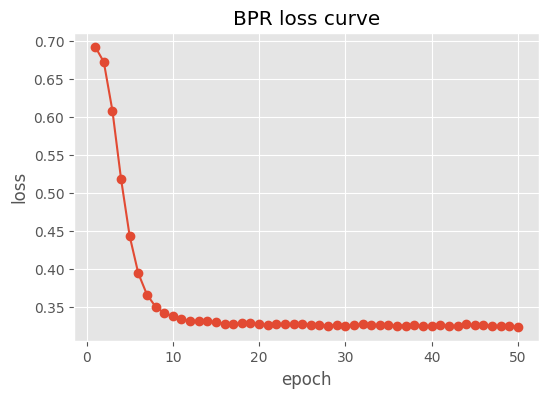

In [14]:

if history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['epoch'] for h in history], [h['loss'] for h in history], marker='o')
    plt.title('BPR loss curve')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
else:
    print('History is empty (training not run).')


In [15]:

val_metrics = evaluate_ranking(lightgcn, train_user_pos, val_pos, num_items, device=DEVICE)
test_metrics = evaluate_ranking(lightgcn, train_user_pos, test_pos, num_items, device=DEVICE)
print('Validation metrics:', json.dumps(val_metrics, indent=2))
print('Test metrics     :', json.dumps(test_metrics, indent=2))


Validation metrics: {
  "recall@10": 0.08288538656226092,
  "recall@20": 0.14249899554856188,
  "ndcg@10": 0.07787027417251854,
  "ndcg@20": 0.09661839889588188,
  "coverage": 0.006879178374188548
}
Test metrics     : {
  "recall@10": 0.0924845041726823,
  "recall@20": 0.1429400456848805,
  "ndcg@10": 0.09228743154847817,
  "ndcg@20": 0.10569131344501402,
  "coverage": 0.006879178374188548
}


Best threshold on validation pairs: 0.600


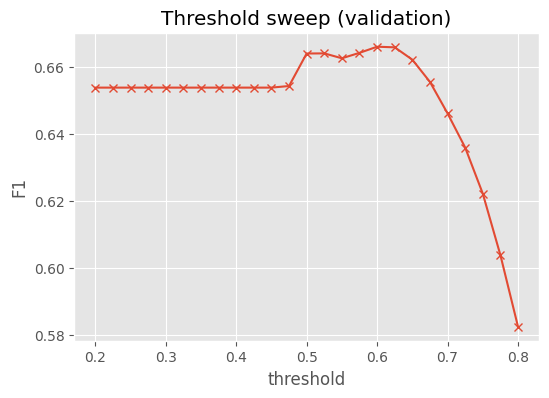

In [16]:

best_threshold, threshold_history = tune_threshold(lightgcn, val_full, device=DEVICE)
print(f'Best threshold on validation pairs: {best_threshold:.3f}')
if threshold_history:
    plt.figure(figsize=(6, 4))
    plt.plot([h['threshold'] for h in threshold_history], [h['f1'] for h in threshold_history], marker='x')
    plt.xlabel('threshold')
    plt.ylabel('F1')
    plt.title('Threshold sweep (validation)')
    plt.show()


In [17]:

def run_inference(model: nn.Module, user2idx: Dict[int, int], item2idx: Dict[int, int],
                  idx2user: Dict[int, int], idx2item: Dict[int, int], input_df: pd.DataFrame,
                  threshold: float, popularity_backup: Dict[int, float]):
    model.eval()
    user_emb, item_emb = model.get_embeddings()
    outputs = []
    recommends = 0
    for row in input_df.itertuples():
        raw_user = getattr(row, 'user')
        raw_item = getattr(row, 'item')
        user_idx = user2idx.get(raw_user)
        item_idx = item2idx.get(raw_item)
        if user_idx is None or item_idx is None:
            score = popularity_backup.get(item_idx, 0.0)
        else:
            with torch.no_grad():
                score = torch.sigmoid((user_emb[user_idx] * item_emb[item_idx]).sum()).item()
        rec = 'O' if score >= threshold else 'X'
        if rec == 'O':
            recommends += 1
        outputs.append({'user': raw_user, 'item': raw_item, 'score': float(score), 'recommend': rec})
    result_df = pd.DataFrame(outputs)
    print(result_df[['user', 'item', 'recommend']])
    total = len(result_df)
    print(f"Total recommends = {recommends}/{total}, not recommend = {total - recommends}/{total}")
    return result_df

demo_df = ratings_df[['user', 'item']].head(5)
_ = run_inference(lightgcn, user2idx, item2idx, idx2user, idx2item, demo_df, best_threshold, popularity_scores)


   user  item recommend
0     1    16         O
1     1    24         O
2     1    32         O
3     1    47         O
4     1    50         O
Total recommends = 5/5, not recommend = 0/5


## 회고 및 다음 단계
- LightGCN 구현은 `docs/claude_v2_gnn.md` 설정(embedding=64, layer=3, BPR, neg ratio=4)을 따른다.
- 데이터 분리/평가/임계값 파이프라인은 `docs/implementation_plan.md` 기반으로 구성되어 DL 버전과 공유 가능하다.
- 성능 개선 여지: label threshold 3.5 실험, hard negative sampling, contrastive 보조 loss, ensemble.
